In [1]:
import random
import sys
sys.path.append("../../../")
from simulation_classes.eta.car import Cars
from simulation_classes.eta.CWPTable import CWPTable
from simulation_classes.eta.SimulationClass import ETASimulation
sys.path.append("../")
from utils import find_delta_v_list, find_delta_x_list
from tqdm.notebook import tqdm

### このシミュレーションコードでは以下のパラメータを動かす
- 大域密度
- 車の台数
- TTC

In [2]:
""" 初期設定（独立変数群）"""
CAR_NUM = 15 #時間窓内の車の総数
START_TIME = 0
TOTAL_LENGTH = 2000 # 入り口から出口までの距離 [m]
WAYPOINTS_NUM = 10 #constrained way pointの数
ORIFITH_LENGTH = 5 # 整流区間長さ. 最後のCWPのindexで指定。
MEAN_SPEED = 20 # 秒速[m/s]として定義
SCALE_FACTOR = 20 #シミュレーション上で距離を変換するための係数
TIME_STEP = 1
TOTAL_TIME = 100
V_MAX = 40

# ETAに関する設定
GLOBAL_TIME_WINDOW = 100  # Strategic Phaseでの時間幅
BATCH_NUM = 1
WINDOW_SIZE = (GLOBAL_TIME_WINDOW / BATCH_NUM)
DESIRED_TTC = 5 # 目標とする車間時間 [s]
DESIRED_SPEED = 21 # 目標とする出口速度 [m/s]

# 車のパラメータ
MAX_ACC_REAL_WORLD = 2 # 0.2Gくらい
MIN_ACC_REAL_WORLD = 2 # 0.5Gくらい
FRONT_BRAKE_REAL_WORLD = 8 # 0.8Gくらい

helly_params = {
    "max_accel":  MAX_ACC_REAL_WORLD,
    "min_accel": 2,
    "front_car_brake":FRONT_BRAKE_REAL_WORLD / SCALE_FACTOR,
    "rear_brake_acc":2,
    "response_time":0.5, #秒で入れる,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1.1,
    "isRss":False
  }

def crt_params_list():
    time_window_list = [50, 100, 150, 200]
    car_num_list = [5,10, 20, 40]
    TTC_list = [1,3,5]
    return [{"window": w, "car_num": car_num, "TTC":ttc} for w in time_window_list for car_num in car_num_list for ttc in TTC_list]

In [3]:
"""
続いてシミュレーションの用意
パラメータの組み合わせはparamListという変数にまとめて格納されているものとし、paramListを一つ一つ取り出してシミュレーションする
"""
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
group_id = 0
iterations = 5 # 1回のparamListについて何回シミュレーションするか

simulation_list = []
paramList = crt_params_list()
simulation_length = iterations * len(paramList)
last_simulation_list = []
print(simulation_length)

for paramSet in tqdm(paramList):
    for i in range(2):
        # ここからシミュレーション開始
        arrival_times = sorted([random.uniform(0, paramSet["window"]) for _ in range(paramSet["car_num"])])
        CARS = [Cars(arrival_time=time, index=index, mean_speed=MEAN_SPEED, \
              helly_params=helly_params, group_id=group_id, order_in_group=index)
              for index, time in enumerate(arrival_times)]
        global_params = {"WINDOW_SIZE":WINDOW_SIZE, "START_TIME":START_TIME, "DESIRED_TTC":paramSet["TTC"], \
                         "ORIFITH_EXIT_INDEX":ORIFITH_LENGTH, "DESIRED_SPEED": DESIRED_SPEED, "V_MAX":V_MAX, "CAR_NUM":paramSet["car_num"]}

        
        cwp_table_controlled = CWPTable(waypoints = WAYPOINTS, algorithm = "CONTROLLED", \
                     global_params = global_params)
        cwp_table_simpler = CWPTable(waypoints = WAYPOINTS, algorithm = "KISS", \
                     global_params = global_params)

        simulation_params = {"TOTAL_TIME": paramSet["window"]+50, "TIME_STEP":TIME_STEP}

        # 続いてシミュレーションオブジェクトを初期化
        eta_simulation_controlled = ETASimulation(CARS=CARS, CWPTable=cwp_table_controlled, simulation_params=simulation_params)
        eta_simulation_simpler = ETASimulation(CARS=CARS, CWPTable=cwp_table_simpler, simulation_params=simulation_params)
        last_simulation_list = [{"simulation_obj": eta_simulation_controlled, "algorithm":"CONTROLLED", **paramSet}]

        # 実行
        eta_simulation_simpler.conduct_simulation()
        eta_simulation_controlled.conduct_simulation()

        simulation_list.append({"simulation_obj": eta_simulation_simpler, "algorithm":"KISS", **paramSet})
        simulation_list.append({"simulation_obj": eta_simulation_controlled, "algorithm":"CONTROLLED", **paramSet})

       
print("DONE.")

240


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [26]:
# シミュレーションにミスがあった時のデバッグ用のセル

In [6]:
simObj = last_simulation_list[0]
print(simObj)
cars = simObj["simulation_obj"].CARS
arrival_times = [car.arrival_time for car in cars]
print(arrival_times)

simObj["simulation_obj"].conduct_simulation()


{'simulation_obj': <simulation_classes.eta.SimulationClass.ETASimulation object at 0xffff6c195b50>, 'algorithm': 'CONTROLLED', 'window': 200, 'car_num': 40, 'TTC': 5}
[0.5527287589814023, 6.508693483112649, 8.934832106964485, 9.226237078222589, 10.364016039849444, 19.457133635240776, 26.906344974418616, 27.78868579602516, 32.07789815148867, 46.69675889819776, 56.98609799577874, 61.363907405649364, 61.69283656092082, 66.07307099284854, 66.20499569749907, 66.88044282223946, 70.80867250549166, 71.86270895815308, 93.68107889910439, 104.90437515199089, 112.91666087829675, 119.70059482080457, 122.34395339916027, 125.79871481435352, 139.51084362844114, 140.4986386382777, 150.88302203083458, 151.05237057669032, 154.23841319159783, 165.3011548436872, 166.94897086877828, 167.8372825698977, 171.51735090078753, 174.9349173068371, 176.76834518726437, 179.54123606769048, 189.9043379487732, 194.47722996561996, 196.69607396643448, 198.9466932623715]


384
{'simulation_obj': <simulation_classes.eta.SimulationClass.ETASimulation object at 0xffff6c201190>, 'algorithm': 'KISS', 'window': 50, 'car_num': 5, 'TTC': 5}


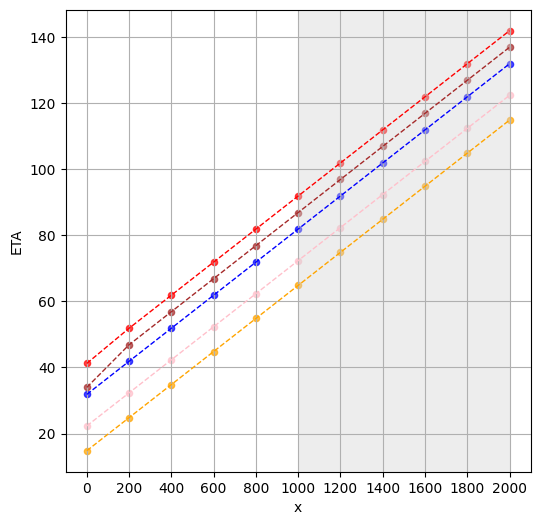

In [7]:
sample_simulation_obj = simulation_list[20]
print(len(simulation_list))
print(simulation_list[20])
simulation = sample_simulation_obj["simulation_obj"]
simulation.cwp_table.plot()
